# Optimal Pricing Strategy

### The optimal price equation

For a given product with features $x$ (among them the cost $c$), let $f(x)$ be a pricing strategy. Let the demand at price $f$ of product $x$ be $D(x, f)$, which corresponds to the probability that the client purchases the product given the features $x$ and the set price $f$.

The expected revenue is $R = \mathbb E[f-c]$, where
$$\mathbb E[f-c] = \int dx (f(x)-c) D(x, f) P(x),$$
where $P(x)$ is the frequency with which a product with features $x$ is offered.

The optimal pricing must fullfill the optimality condition
$$
    \left.\frac{\delta \mathbb E[f-c]}{\delta f}\right|_{f=f^*} = \mathbb E\left[D(x, f^*) + (f^* - c)\left.\frac{\partial D}{\partial f}\right|_{f=f^*}\right] = 0
$$

where $\frac{\partial D}{\partial f}$ is the elasticity of the demand at price $f$.

This results in the **optimal price equation** for a given product with features $x$:
$$
    (f^*-c)\left.\frac{\partial D(x, f)}{\partial f}\right|_{f=f^*}= - D(x, f^*)
$$


This equation has no trivial solution and requires taiolerd numerical methods for each specific demand function $D(x, f)$

Since the optimal price equation is linear in $D$ we can replace the demand by its normalized value, i.e., the probability that a customer purchases the product at given features $x$ and set price $f$, $D(x, f) = P(\textrm{purchase}|x, f)$.

### Modelling demand with a logistic regression

For a logistic regression, this probability can be expressed as
$$
    D(x, f) = \frac{1}{1+\exp(-k^\top\cdot x - z - \gamma f)}
$$
where $x$ is the full set of features (excluding `bag_total_price`), $k$ are the associated model parameters and $z$ is the intercept.  

The elasticity then becomes
$$
    \frac{\partial D(x, f)}{\partial f} = D(x, f)(1-D(x, f))\gamma
$$
and the optimal price equation can be written as
$$
    (f^*(x)-c) (1-D(x, f^*(x)))\gamma + 1 = 0
$$

### Example

Suppose $x$ and $\theta$ are given so that $\theta^\top x = k$ and by measuring money in suitable units we can assume $\gamma=1$. The optimal price equation then becomes
$$
    f^*=c + \frac{e^{-k-f^*}}{1+e^{-k-f^*}}
$$

In [1]:
from src.benchmark import Benchmark
from src.models.baseline import LogisticRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.plots import prob_hist
from scipy.optimize import fsolve
from scipy.special import expit
import warnings

file_path = 'data/export.parquet'
df = pd.read_parquet(file_path)

# Define features and target variable
X = df.drop(['Bag_Purchased'], axis=1)
y = df['Bag_Purchased']

model = LogisticRegressor()

model.fit(X, y)

y_pred = model.pipeline.predict(X)

y_pred.mean(), model.model.intercept_[0]

/Users/amonras/.pyenv/versions/3.12.2/envs/kiwi/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.09634085213032581, -0.10855901653957076)

In [2]:
theta = pd.Series(model.model_coefficients())
intercept = model.model.intercept_ 

### Explore class imbalance

In [3]:
# Compute contrubutions from other features
X_transf = pd.DataFrame(
    model.preprocessor.transform(X),
    columns = model.get_feature_names()
)
theta = pd.Series(model.model_coefficients())

# This is the full set of predictors, including the sell price
KX = X_transf.dot(theta).rename('kx') + intercept

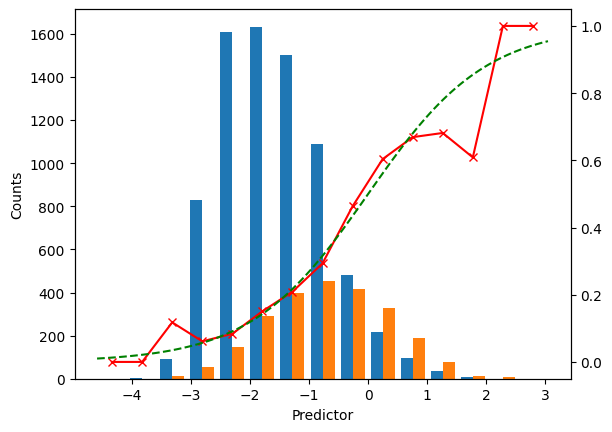

In [4]:
hist = prob_hist(
    predictor=KX,
    target=y,
    nbins=15
)

In [5]:
# What's the predicted demand? (observed demand is 24%)
expit(KX).mean()

0.23926352262474962

## Prepare the optimal price equation

Let's compute the contribution of all features, leaving aside the contribution from the total price. According to our model, the demand function is given by
$$
    D(x, f) = \textrm{expit}(Z + \gamma f)
$$
where $Z=k^\top x + \textrm{intercept}$. 

The cost $c=$ `bag_base_price` should not be a part of the feature vector $x$. It is already filtered out by the pipeline in `X_transf`.

We split the `total_bag_price` contribution from the signal, in order to optimize for it.

In [19]:
cost = X['bag_base_price'].rename('cost')
Z = (X_transf.drop('bag_total_price', axis=1).dot(theta.drop('bag_total_price')) + intercept).rename('kx')
gamma = theta['bag_total_price']

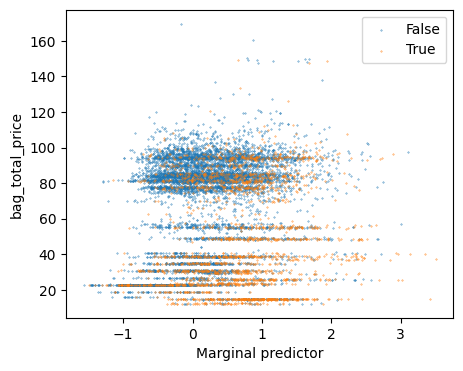

In [32]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(Z[~y], X_transf['bag_total_price'][~y], s=.1, label=False)
plt.scatter(Z[y], X_transf['bag_total_price'][y], s=.1, label=True)
ax.set_xlabel('Marginal predictor')
ax.set_ylabel('bag_total_price')
ax.legend()

In [7]:
def optimal_price_equation(f, c, z, g):
    return g * (f - c) * (1 - expit(z + g * f)) + 1
    
def optimize(cost, Z):
    return fsolve(optimal_price_equation, x0=1.5 * cost, args=(cost, Z, gamma))[0]

In [8]:
warnings.filterwarnings('ignore', 'The iteration is not making good progress')

optimal_price = pd.concat([cost, Z], axis=1).apply(
    lambda row: optimize(row['cost'], row['kx']),
    axis=1
).rename('optimal_price')

results = pd.concat([
    X[['bag_base_price', 'bag_total_price', 'price']], 
    y, 
    optimal_price
], axis=1)

# Add the success probability at optimal price
results['prob'] = expit(Z + gamma * results['optimal_price'])

# Add expected revenue
results['exp_revenue'] = (results['optimal_price'] - results['bag_base_price'])*results['prob']
results['actual_revenue'] = (results['bag_total_price'] - results['bag_base_price'])*results['Bag_Purchased']
results.sample(8)

,bag_base_price,bag_total_price,price,Bag_Purchased,optimal_price,prob,exp_revenue,actual_revenue
1164,45.570000,77.469002,31.27,False,86.536248,0.065957,2.702021,0.000000
6764,48.320000,82.144005,47.63,False,90.632550,0.095677,4.048323,0.000000
1329,32.349998,54.994999,75.89,False,85.045168,0.273857,14.430943,0.000000
547,55.150002,93.755005,35.86,False,98.989129,0.127167,5.574901,0.000000
7988,20.309999,34.527000,195.62,False,65.283250,0.149178,6.709024,0.000000
5752,32.299999,54.910000,180.01,True,85.480103,0.280479,14.915877,22.610001
4966,57.310001,97.427002,177.96,False,99.646496,0.096188,4.072268,0.000000
4750,57.750000,98.175003,42.59,False,100.593274,0.106879,4.579047,0.000000


In [9]:
results.mean()

bag_base_price      38.009509
bag_total_price     64.616167
price              106.072021
Bag_Purchased        0.238997
optimal_price       83.651846
prob                 0.151489
exp_revenue          7.378110
actual_revenue       4.949967
dtype: float64

### Explore results

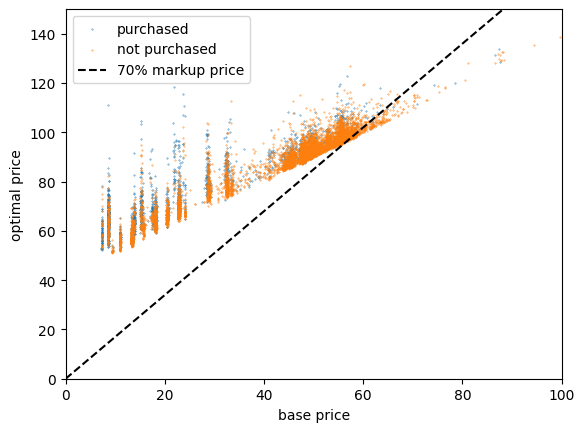

In [17]:
fig, ax = plt.subplots()
ax.scatter(results['bag_base_price'][y], results['optimal_price'][y], label='purchased', s=.1)
ax.scatter(results['bag_base_price'][~y], results['optimal_price'][~y], label='not purchased', s=.1)
ax.set_xlabel('base price')
ax.set_ylabel('optimal price')
line = np.array([0, 150])
ax.plot(line, 1.7 * line, 'k--', label='70% markup price')
ax.set_xlim([0, 100])
ax.set_ylim([0, 150])
ax.legend()

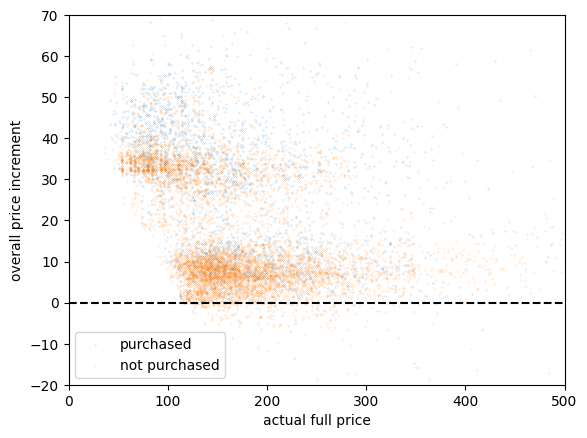

In [18]:
fig, ax = plt.subplots()
x = results['price'] + results['bag_total_price']

ax.scatter(x[y], results['price'][y] + results['optimal_price'][y] - x[y], label='purchased', s=.01)
ax.scatter(x[~y], results['price'][~y] + results['optimal_price'][~y] - x[~y], label='not purchased', s=.01)
ax.set_xlabel('actual full price')
ax.set_ylabel('overall price increment')
ax.plot([0, 600], [0, 0], 'k--')
ax.set_xlim([0, 500])
ax.set_ylim([-20, 70])
ax.legend()